In [1]:
from tvb.simulator.simulator import Simulator
from tvb.datatypes.connectivity import Connectivity
from tvb.contrib.inversion.sbiInference import sbiModel

import tvb.simulator.models
import tvb.simulator.integrators
import tvb.simulator.coupling
import tvb.simulator.monitors

import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import arviz as az
import pickle

%load_ext autoreload
%autoreload 2

/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
#run_ids = [
#    "2022-09-13_08-20-56-466197_instance",
#    "2022-09-13_08-20-56-525471_instance",
#    "2022-09-13_08-20-56-675430_instance",
#    "2022-09-13_08-20-56-756109_instance"
#]

#run_ids = [
#    "2022-09-13_08-49-00-122871_instance",
#    "2022-09-13_08-49-00-133581_instance",
#    "2022-09-13_08-49-00-218087_instance",
#    "2022-09-13_08-49-00-292717_instance"
#]

#run_ids = [
#    "2022-09-13_09-35-43-404460_instance",
#    "2022-09-13_09-35-43-411359_instance",
#    "2022-09-13_09-35-43-450581_instance",
#    "2022-09-13_09-35-43-452609_instance"
#]

run_ids = [
    "2022-09-13_16-37-13-003930_instance",
    "2022-09-13_16-37-13-010276_instance",
    "2022-09-13_16-37-13-112678_instance",
    "2022-09-13_16-37-13-116596_instance"
]

In [3]:
with open(f"sbi_data/inference_data/{run_ids[0]}.pkl", "rb") as f:
    instance_params = pickle.load(f)
    simulation_params = instance_params["simulation_params"]

In [4]:
# Model
oscillator_model = getattr(tvb.simulator.models, simulation_params["model"])(
    a=np.asarray([simulation_params["a_sim"]]),
    b=np.asarray([simulation_params["b_sim"]]),
    c=np.asarray([simulation_params["c_sim"]]),
    d=np.asarray([simulation_params["d_sim"]]),
    I=np.asarray([simulation_params["I_sim"]]),
)
oscillator_model.configure()

# Integrator
integrator = getattr(tvb.simulator.integrators, simulation_params["integrator"])(dt=simulation_params["dt"])
integrator.noise.nsig = np.array([simulation_params["nsig"]])
integrator.noise.configure()
integrator.noise.configure_white(dt=integrator.dt)
integrator.set_random_state(random_state=None)
integrator.configure()
integrator.configure_boundaries(oscillator_model)

In [5]:
X = instance_params["obs"]

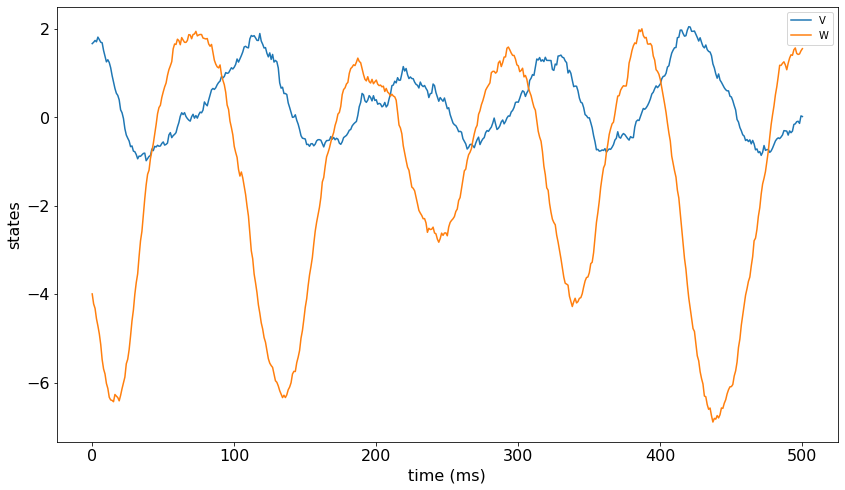

In [6]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="V")
plt.plot(X[:, 1, 0, 0], label="W")
plt.ylabel("states", fontsize=16)
plt.xlabel("time (ms)", fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

### SNPE inference

In [7]:
snpe_model = sbiModel(
    method="SNPE", 
    obs=X,
    model_instance=oscillator_model,
    integrator_instance=integrator
)

In [8]:
snpe_model.load(f"{run_ids[0]}.pkl")

In [9]:
print(snpe_model.priors.loc.numpy(), np.diag(snpe_model.priors.scale_tril))

[ 2.e+00 -1.e+01  3.e-03  0.e+00] [1.0e+00 5.0e+00 1.5e-03 1.0e+00]


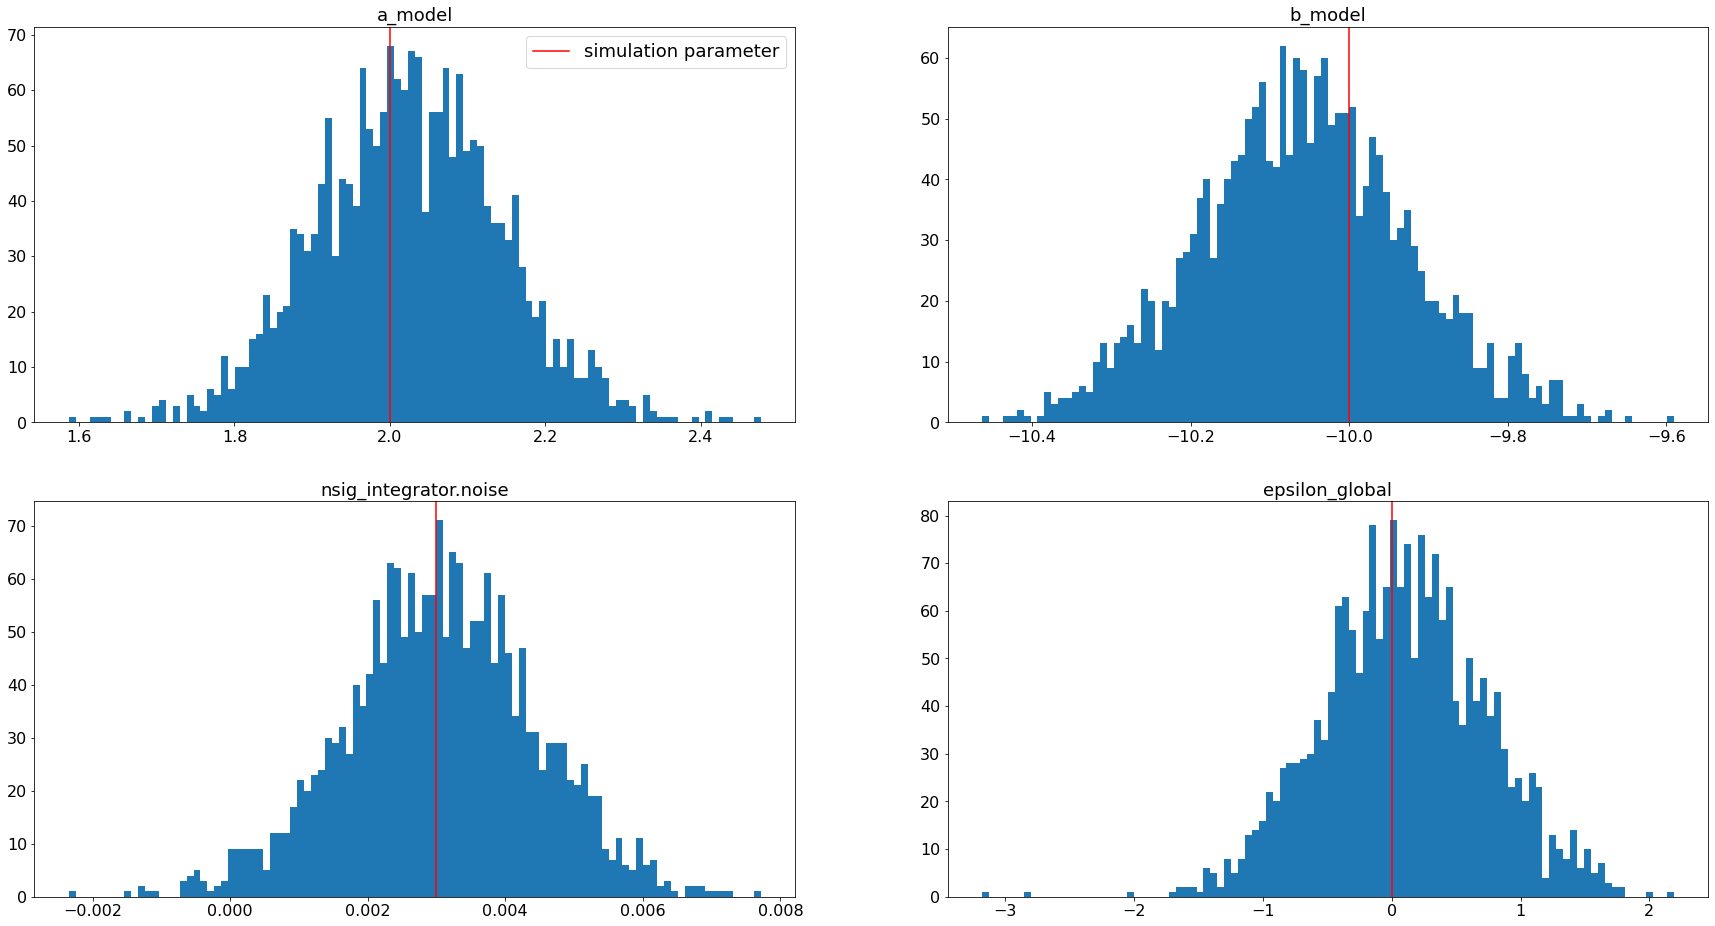

In [10]:
snpe_model.plot_posterior_samples(
    init_params={"a_model": simulation_params["a_sim"],
                 "b_model": simulation_params["b_sim"],
                 "nsig_integrator.noise": 0.003,
                 "epsilon_global": 0.0}
)

In [11]:
print("posterior std dev:", snpe_model.posterior_samples.std(dim=0).numpy())
print("prior std dev:", torch.diag(snpe_model.priors.scale_tril).numpy())
print("shrinkages:", snpe_model.posterior_shrinkage().numpy())

posterior std dev: [0.11922083 0.13226609 0.00138069 0.63765925]
prior std dev: [1.0e+00 5.0e+00 1.5e-03 1.0e+00]
shrinkages: [0.98578639 0.99930023 0.15275349 0.59339067]


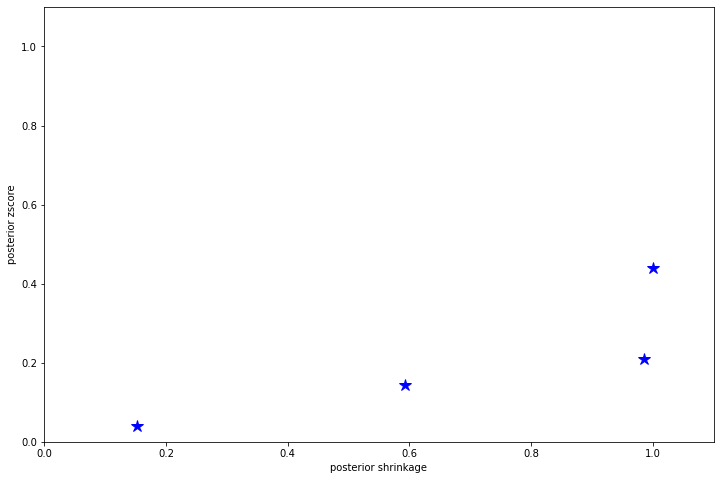

In [24]:
f2 = plt.figure(figsize=(12,8))
plt.plot(snpe_model.posterior_shrinkage(), snpe_model.posterior_zscore(), 
         color="blue", linewidth=0, marker="*", markersize=12)
plt.xlabel("posterior shrinkage")
plt.ylabel("posterior zscore")
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.plot();

In [13]:
posterior_sample = snpe_model.get_sample()[0]
posterior_sample

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([ 2.0273e+00, -1.0092e+01,  3.2425e-03, -1.7012e-01])

In [19]:
posterior_obs = snpe_model.simulation_wrapper(params=posterior_sample)
posterior_obs = posterior_obs.numpy().reshape(X.shape, order="F")

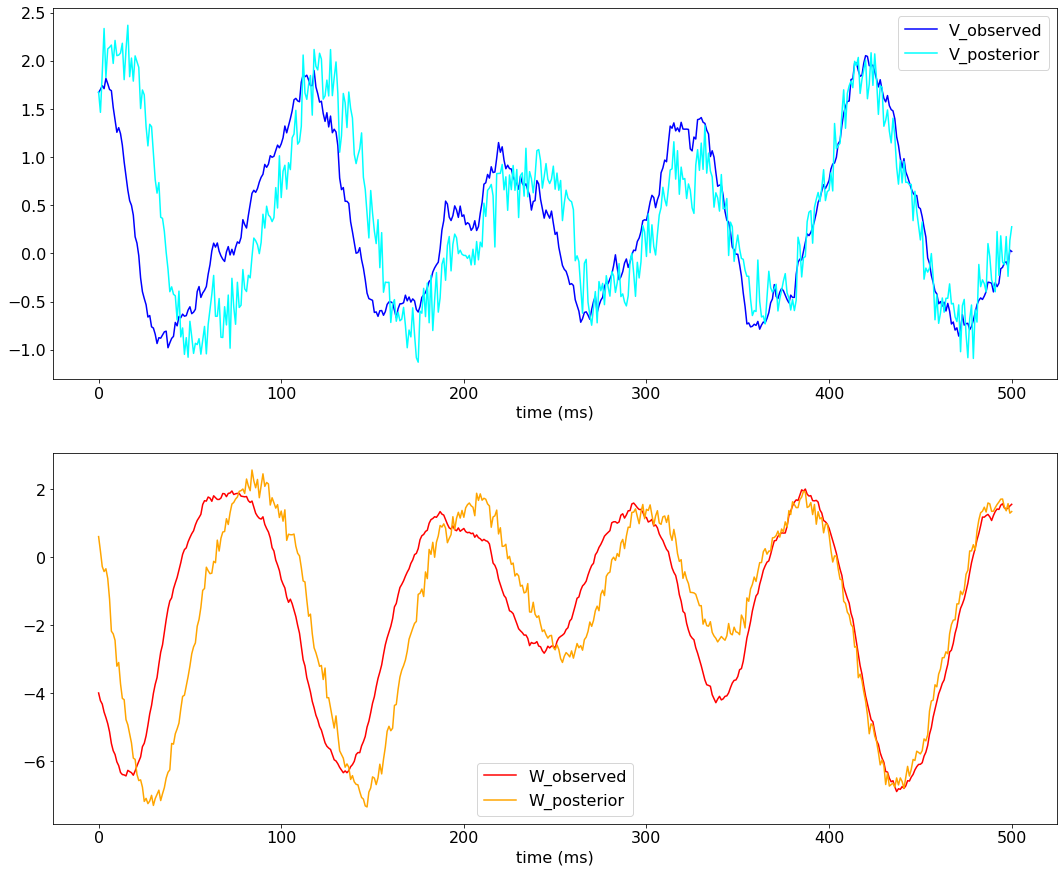

In [20]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(snpe_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_observed", color="blue")
axes3[0].plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(snpe_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_observed", color="red")
axes3[1].plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [ ]:
#snpe_model.save()